# Hyperparamter Tuning
There are 3 types of jobs in Azure. Command jobs are to execute a single script. 
Sweep jobs are to perform hyperparamter tuning. And finally Pipeline jobs are to run multiple scripts or components.

In [1]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.16.1
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


My credentials, subscription id, resource group and workspace info, are all stored in a file called config.py. You have to make sure that you have yours in that file.

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# My subscription id, resource group and workspace are all in the file below.
import config

In [3]:
ml_client = MLClient(
    DefaultAzureCredential(), config.subscription_id, config.resource_group, config.workspace
)

In [5]:
# We would like to create a folder for the script files

import os

script_folder = 'src'
os.makedirs(script_folder, exist_ok=True)

In [6]:
%%writefile $script_folder/train.py
# import libraries
import mlflow
import argparse
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def main(args):
    # read data
    print(f'This is the path, haa {args.training_data}')
    df = get_data(args.training_data)

    # split data
    X_train, X_test, y_train, y_test = split_data(df)

    # train model
    model = train_model(args.reg_rate, X_train, X_test, y_train, y_test)

    # evaluate model
    eval_model(model, X_test, y_test)

# function that reads the data
def get_data(path):
    print("Reading data...")
    df = pd.read_csv(path)
    
    return df

# function that splits the data
def split_data(df):
    print("Splitting data...")
#     df = pd.get_dummies(df, columns = ['Sex'], dtype=int)
#     le = LabelEncoder()
#     df['Survived'] = le.fit_transform(df['Survived'])

    X = df.drop(['Survived'], axis=1)
    y = df['Survived']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

    return X_train, X_test, y_train, y_test

# function that trains the model
def train_model(reg_rate, X_train, X_test, y_train, y_test):
    mlflow.log_param("Regularization rate", reg_rate)
    print("Training model...")
    model = LogisticRegression(C=1/reg_rate, solver="liblinear").fit(X_train, y_train)

    return model

# function that evaluates the model
def eval_model(model, X_test, y_test):
    # calculate accuracy
    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)
    print('Accuracy:', acc)
    mlflow.log_metric("training_accuracy_score", acc)

    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' + str(auc))
    mlflow.log_metric("AUC", auc)

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig("ROC-Curve.png")
    mlflow.log_artifact("ROC-Curve.png")    

def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--training_data", dest='training_data',
                        type=str)
    parser.add_argument("--reg_rate", dest='reg_rate',
                        type=float, default=0.01)

    # parse args
    args = parser.parse_args()

    # return args
    return args

# run script
if __name__ == "__main__":
    # add space in logs
    print("\n\n")
    print("*" * 60)

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")

Overwriting src/train.py


In [7]:
from azure.ai.ml import command, Input
from azure.ai.ml.constants import AssetTypes, InputOutputModes

# configure job
data_asset = ml_client.data.get("titanic_ds4", version="1")

job = command(
    code="./src",
    command="python train.py --training_data ${{inputs.data}} --reg_rate ${{inputs.reg_rate}}",
    inputs={"data": Input(path=data_asset.id,
                 type=AssetTypes.URI_FILE,
                 mode=InputOutputModes.RO_MOUNT
                 ),
            "reg_rate": 0.01,
    },
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    compute="sckaraman1",
    display_name="titanic-lives",
    experiment_name="titanic-lives-1",
    tags={"model_type": "LogisticRegression"}
    )

In [9]:
# Let's make sure that our code works first, before trying hyperparameters

returned_job = ml_client.create_or_update(job)
aml_url = returned_job.studio_url
print("Monitor your job at", aml_url)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading src (0.0 MBs): 100%|████████

Monitor your job at https://ml.azure.com/runs/busy_bulb_13mhtxcy3t?wsid=/subscriptions/a54b1e51-86a2-4073-b2a5-1a79c43cf955/resourcegroups/model_dep/workspaces/ml-workspace&tid=2e5df792-f2e7-43fc-954b-c3dd8d56a02d


We specify the hyperparamters with the Choice object

In [12]:
from azure.ai.ml.sweep import Choice

command_job_for_sweep = job(
    reg_rate=Choice(values=[0.01, 0.1, 1])
)

In [13]:
# apply the sweep parameter to obtain the sweep_job
sweep_job = command_job_for_sweep.sweep(
    compute="sckaraman1",
    sampling_algorithm="grid",
    primary_metric="training_accuracy_score",
    goal="Maximize",
)

# set the name of the sweep job experiment
sweep_job.experiment_name="sweep-diabetes"

# define the limits for this sweep
sweep_job.set_limits(max_total_trials=4, max_concurrent_trials=2, timeout=7200)

In [14]:
returned_sweep_job = ml_client.create_or_update(sweep_job)
aml_url = returned_sweep_job.studio_url
print("Monitor your job at", aml_url)

Monitor your job at https://ml.azure.com/runs/amiable_truck_z58c6qq3p0?wsid=/subscriptions/a54b1e51-86a2-4073-b2a5-1a79c43cf955/resourcegroups/model_dep/workspaces/ml-workspace&tid=2e5df792-f2e7-43fc-954b-c3dd8d56a02d


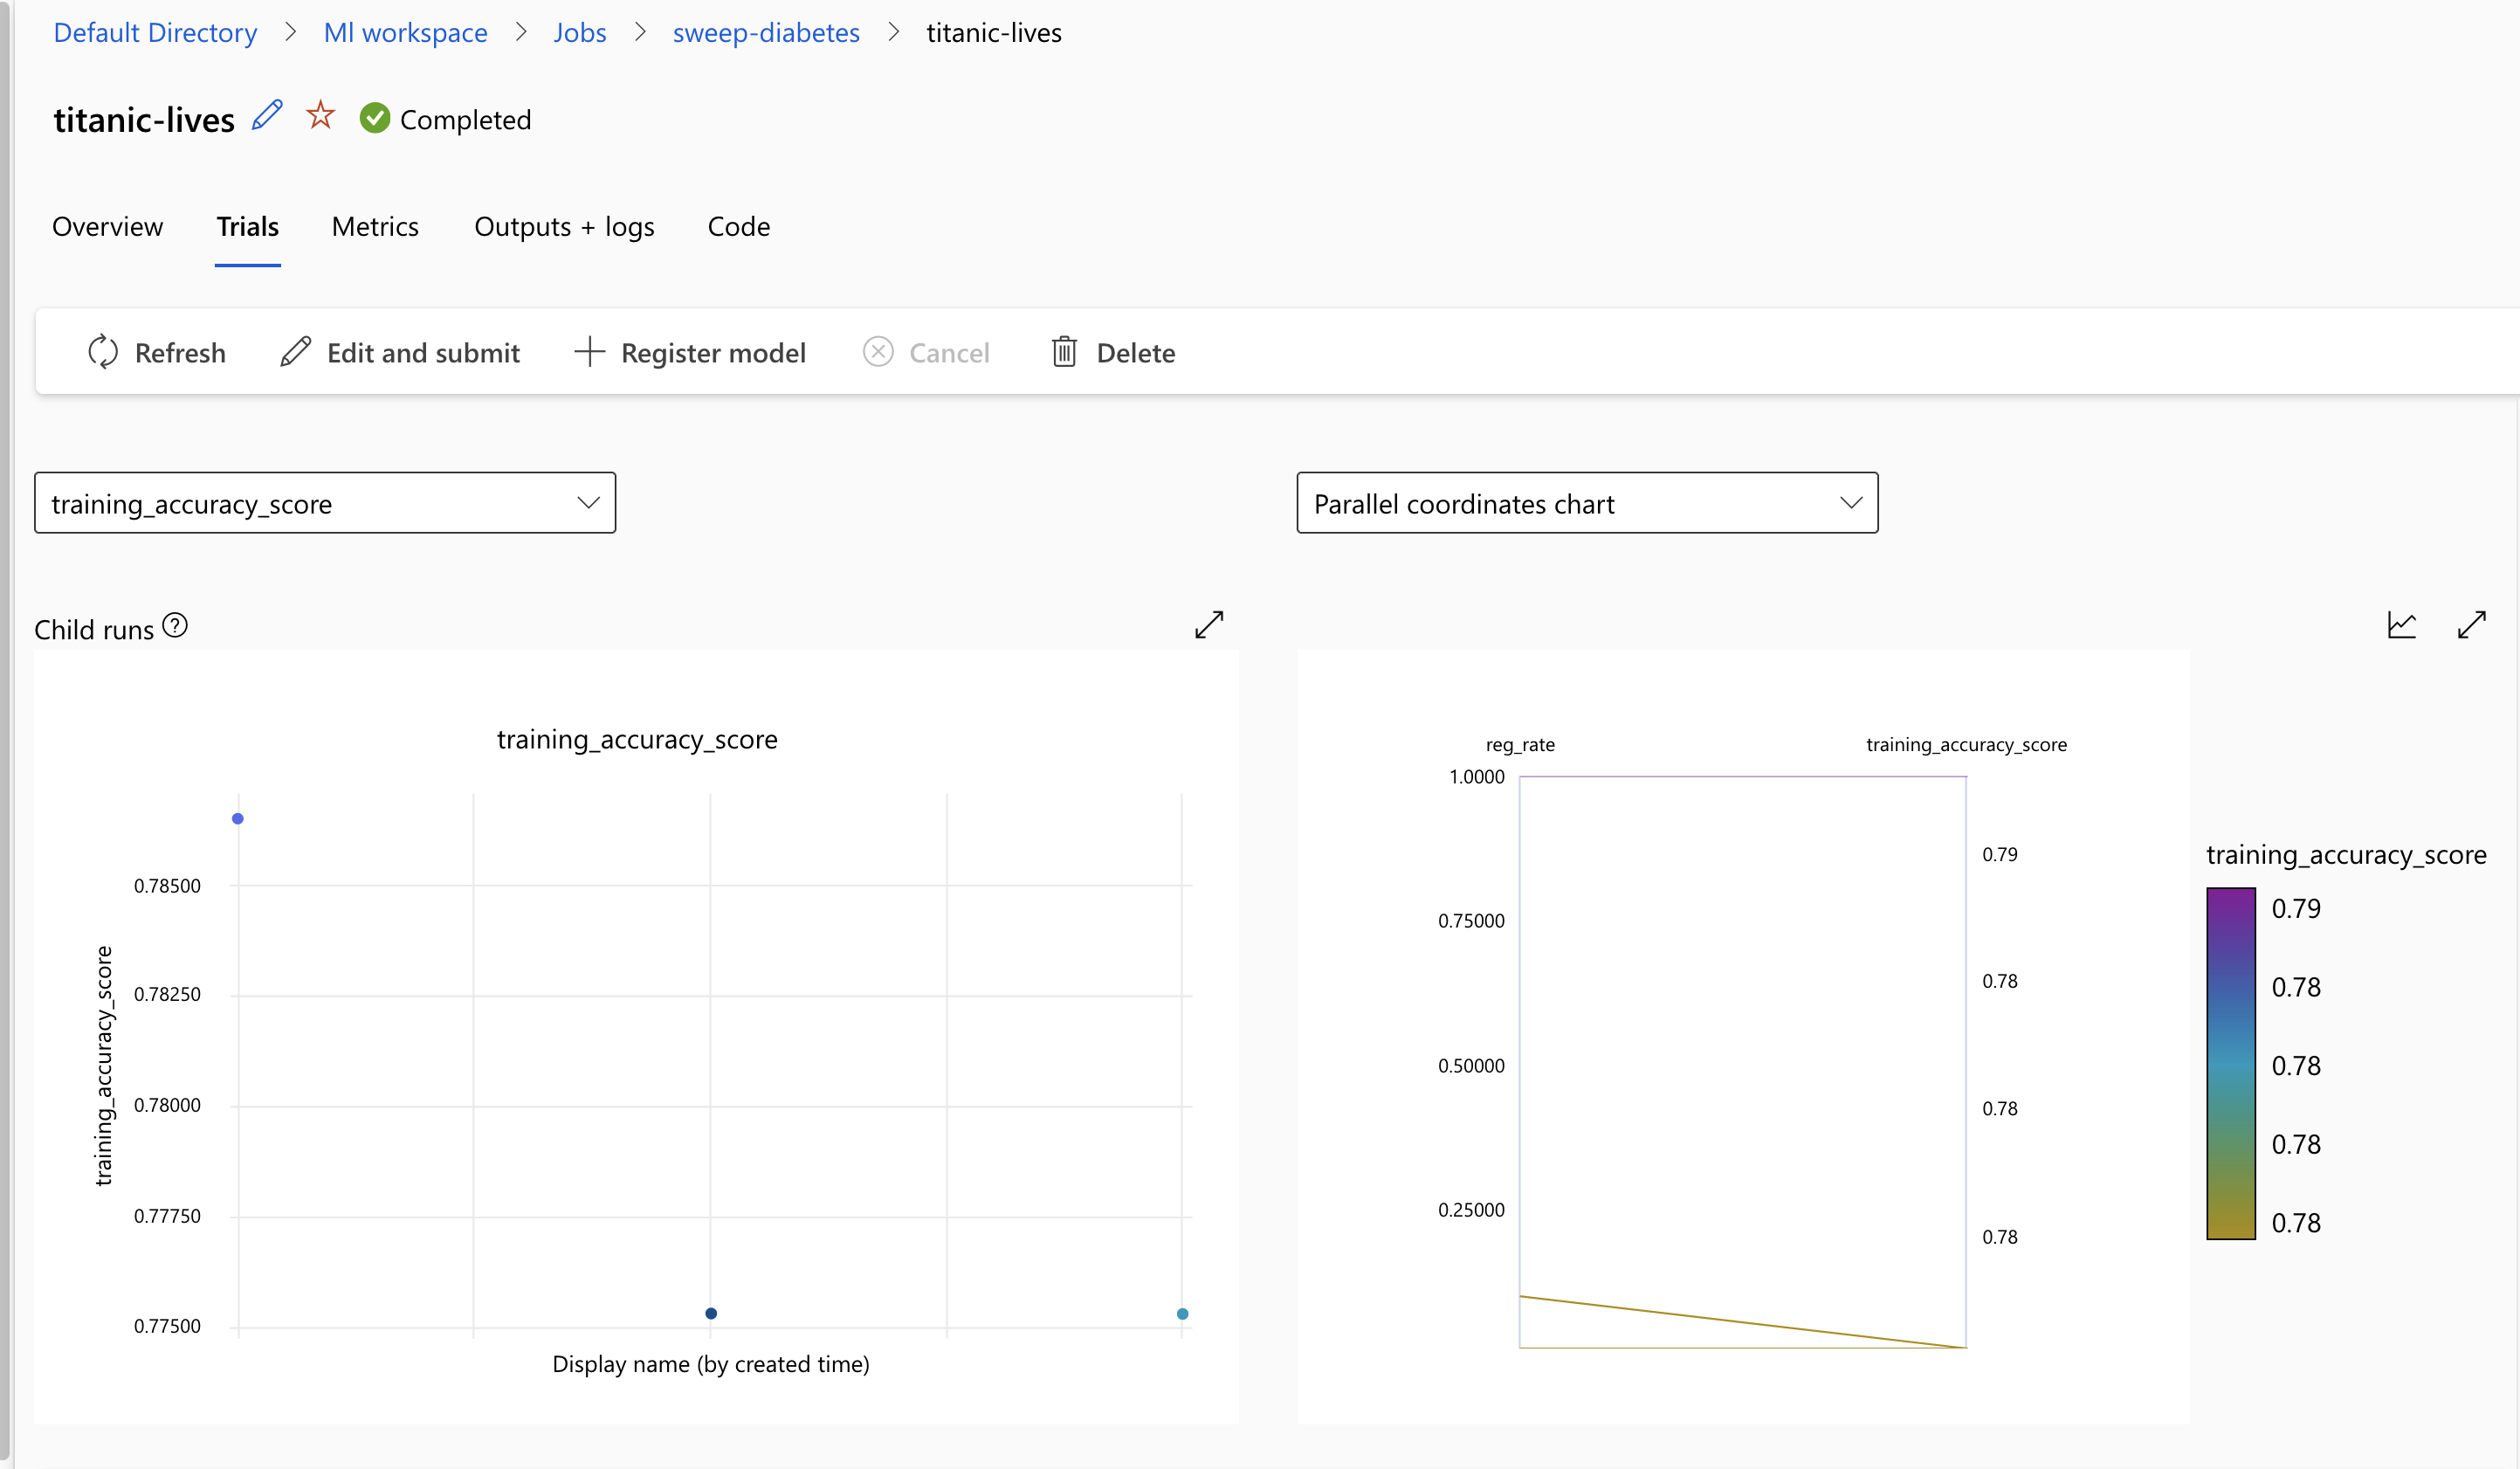